In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_atom_element  
import prolif as plf
import sys, types, tqdm.std
import dill, tqdm
from tqdm.auto import tqdm as _tqdm_singleton
dill.settings['recurse'] = True
if 'tqdm.auto' not in sys.modules:          # patch only if absent
    sys.modules['tqdm.auto'] = types.ModuleType('tqdm.auto')
    sys.modules['tqdm.auto'].tqdm = tqdm.std.tqdm

# load topology and trajectory
#u = mda.Universe("/data/numerik/bzfchewl/data_for_isokann/dcd_input/des_prod_8ef5_stripped_aligned_pH6_propka_3_8ef5_pH6_replica_3/struct1.psf", "/data/numerik/bzfchewl/data_for_isokann/dcd_input/des_prod_8ef5_stripped_aligned_pH6_propka_3_8ef5_pH6_replica_3/traj1.dcd")
u = mda.Universe("/data/numerik/bzfchewl/data_for_isokann/dcd_input/des_prod_8ef5_stripped_aligned_pH74_propka_3_8ef5_pH6/struct1.psf", "/data/numerik/bzfchewl/data_for_isokann/dcd_input/des_prod_8ef5_stripped_aligned_pH74_propka_3_8ef5_pH6/traj1.dcd")
ligand_selection = u.select_atoms("resname LIG")
#protein_selection = u.select_atoms("protein")
protein_selection = u.select_atoms("protein and not name LP*")
ligand_selection, protein_selection




/home/numerik/bzfchewl/.local/lib/python3.12/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)
/home/numerik/bzfchewl/.local/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


(<AtomGroup with 48 atoms>, <AtomGroup with 4722 atoms>)

In [2]:
if hasattr(u.atoms, "chainIDs") and not np.all(u.atoms.chainIDs == ""):
    attr      = "chainIDs"           # PDB column 22, 1-letter
    key_word  = "chainid"            # MDAnalysis selection keyword
else:
    attr      = "segids"             # PDB columns 73-76, up to 4 letters
    key_word  = "segid"

# ── 2. Get the unique labels ──────────────────────────────────────────
labels = np.unique(getattr(u.atoms, attr))

# ── 3. Count residues per label ───────────────────────────────────────
for lbl in labels:
    # Strip spaces so "A   " → "A"
    clean = lbl.strip()
    n_res = len(u.select_atoms(f"{key_word} {clean}").residues)
    print(f"{attr[:-1].capitalize()} {clean}: {n_res} residues")

Segid C2: 291 residues


In [3]:
protein_selection = u.select_atoms(
    "protein and byres around 20.0 group ligand", ligand=ligand_selection
)
protein_selection

<AtomGroup with 3639 atoms>

In [4]:
protein_selection = u.select_atoms(
    "(protein or resname WAT) and byres around 20.0 group ligand",
    ligand=ligand_selection,
)
protein_selection

<AtomGroup with 3639 atoms>

/tmp/ipykernel_2190344/1162995084.py:1: DeprecationWarning: `guess_atom_element` is deprecated!
`guess_atom_element` will be removed in release 3.0.0.
MDAnalysis.topology.guessers is deprecated in favour of the new Guessers API. See MDAnalysis.guesser.default_guesser for more details.
  elements = [guess_atom_element(name) for name in u.atoms.names]


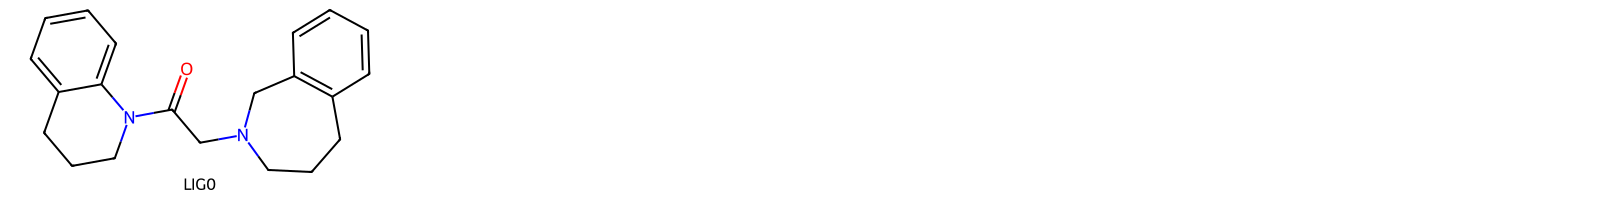

In [5]:
elements = [guess_atom_element(name) for name in u.atoms.names]
u.add_TopologyAttr("elements", elements)

# ------------------------------------------------------------------
# 3 · Convert the ligand AtomGroup to a ProLIF Molecule  ────────────
#    `ligand_selection` was defined earlier — reuse it.
# ------------------------------------------------------------------
ligand_mol = plf.Molecule.from_mda(ligand_selection)

# ------------------------------------------------------------------
# 4 · Quick visual sanity-check (Jupyter-friendly)  ─────────────────
# ------------------------------------------------------------------
plf.display_residues(ligand_mol, size=(400, 200))

In [6]:
#protein_mol = plf.Molecule.from_mda(protein_selection)
# remove the `slice(20)` part to show all residues
#plf.display_residues(protein_mol, slice(20))

In [7]:
plf.Fingerprint.list_available()

['Anionic',
 'CationPi',
 'Cationic',
 'EdgeToFace',
 'FaceToFace',
 'HBAcceptor',
 'HBDonor',
 'Hydrophobic',
 'MetalAcceptor',
 'MetalDonor',
 'PiCation',
 'PiStacking',
 'VdWContact',
 'XBAcceptor',
 'XBDonor']

In [8]:
# use default interactions
fp = plf.Fingerprint(['Cationic','Hydrophobic','PiStacking'])
# run on a slice of the trajectory frames: from begining to end with a step of 10
#fp.run(u.trajectory[::2000], ligand_selection, protein_selection)

In [10]:
fp.run(
    u.trajectory[::200],
    ligand_selection,
    protein_selection,
    n_jobs=10,
    residues=["ILE146","ASP149", "MET153", "TYR328"]
)

  0%|          | 0/51 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 3 interactions: ['Hydrophobic', 'Cationic', 'PiStacking'] at 0x7f9f0323ccb0>

In [ ]:
fp.to_pickle("fingerprint_ph.pkl")
fp = plf.Fingerprint.from_pickle("fingerprint.pkl")

In [11]:
frame_number = 0
ligand_residue = "LIG0"
protein_residue = "ASP149"

fp.ifp[frame_number][(ligand_residue, protein_residue)]

{'Hydrophobic': ({'indices': {'ligand': (20,), 'protein': (4,)},
   'parent_indices': {'ligand': (20,), 'protein': (1179,)},
   'distance': 4.13453972003109},)}

In [12]:
protein_ag = u.select_atoms("protein")
prot_mol = plf.Molecule.from_mda(protein_ag)
met153_ag = u.select_atoms("segid C2 and resname MET and resid 153")

met153_ag = u.select_atoms("segid C2 and resname MET and resid 153")

if len(met153_ag) == 0:
    raise ValueError("No atoms matched MET 153 in segid C2")

# ── 2 · Convert that AtomGroup directly to an RDKit Mol ────────────────
rdmol = met153_ag.convert_to.rdkit()        # works in every MDAnalysis ≥ 2.0

# ── 3 · List atoms that carry a non-zero formal charge ─────────────────
charged = []
for atom in rdmol.GetAtoms():
    q = atom.GetFormalCharge()
    if q != 0:
        ri = atom.GetPDBResidueInfo()       # may be None, handle safely
        atom_name = ri.GetName().strip() if ri else f"IDX{atom.GetIdx()}"
        charged.append((atom_name, atom.GetSymbol(), q))

if charged:
    print("Atoms in MET153.C2 with non-zero formal charge:")
    for name, elem, q in charged:
        print(f"  {name:>4}  element={elem:<2}  formal charge = {q:+}")
else:
    print("All atoms in MET153.C2 have formal charge 0 in the RDKit model.")


All atoms in MET153.C2 have formal charge 0 in the RDKit model.


In [13]:
df = fp.to_dataframe()
# show only the 10 first frames
df.head(10)

ligand             LIG0                                    
protein          ILE146      ASP149      MET153      TYR328
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic
Frame                                                      
0                 False        True       False        True
200                True       False        True       False
400               False       False        True        True
600               False       False        True       False
800               False        True        True        True
1000              False        True        True       False
1200              False       False        True        True
1400              False       False        True       False
1600              False        True        True        True
1800              False        True        True        True

In [14]:
# show only one protein residue (ASP129.A)
df.xs("MET153", level="protein", axis=1).head(5)

ligand,LIG0
interaction,Hydrophobic
Frame,
0,False
200,True
400,True
600,True
800,True


In [15]:
# show only an interaction type (PiStacking)
df.xs("PiStacking", level="interaction", axis=1).head(5)

KeyError: 'PiStacking'

In [16]:
# percentage of the trajectory where each interaction is present
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand             LIG0                                    
protein          MET153      ASP149      TYR328      ILE146
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic
%             92.156863   66.666667   62.745098    1.960784

In [17]:
# same but we regroup all interaction types
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand        LIG0                                
protein     MET153     ASP149     TYR328    ILE146
%        92.156863  66.666667  62.745098  1.960784

In [18]:
# percentage of the trajectory where PiStacking interactions are present, by residue
(
    df.xs("Cationic", level="interaction", axis=1)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

KeyError: 'Cationic'

In [19]:
# %matplotlib ipympl

#fp.plot_barcode()

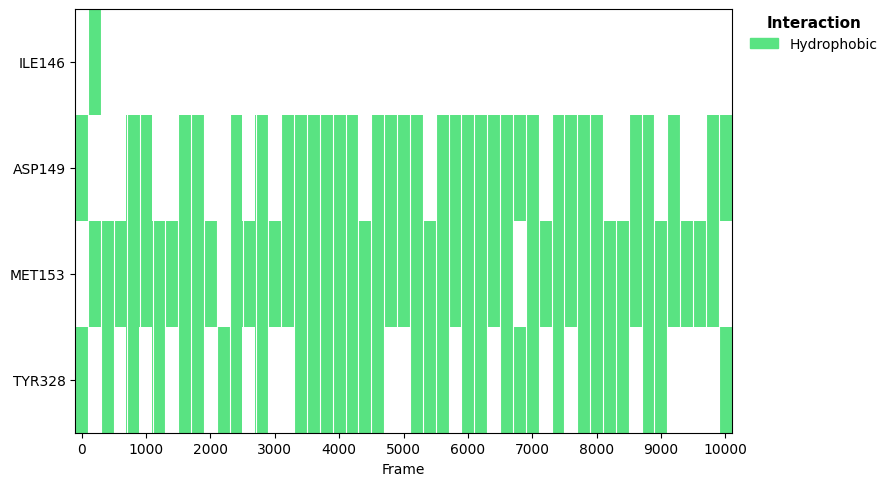

In [20]:
from prolif.plotting.barcode import Barcode
import numpy as np
import matplotlib.pyplot as plt

bar = Barcode.from_fingerprint(fp)
ax  = bar.display(
        figsize=(9, 5),
        residues_tick_location="bottom",
        n_frame_ticks=12,
)

# ── rename “Cationic” → “Salt Bridge” in the legend
leg = ax.get_legend()
for txt in leg.get_texts():
    if txt.get_text() == "Cationic":
        txt.set_text("Salt Bridge")
        break

leg.set_title("Interaction", prop={"weight": "bold", "size": 11})
leg.set_bbox_to_anchor((1.02, 1.0))
leg.set_loc("upper left")
leg.get_frame().set_edgecolor("none")

# ── thin white gaps between frame columns
n_frames = bar.df.shape[1]                # use ‘df’, not ‘data’
ax.set_xticks(np.arange(-0.5, n_frames, 1), minor=True)
ax.grid(which="minor", axis="x",
        color="white", linewidth=0.8)
ax.tick_params(which="minor", bottom=False)   # hide minor tick marks

plt.show()


In [21]:
#fig = ax.figure                       # the Matplotlib Figure object

#fig.savefig("barcode_ph6.2.svg",  format="svg",  bbox_inches="tight")   # crisp, vector
#fig.savefig("barcode_ph6.2.png",  format="png",  dpi=300,  bbox_inches="tight") 

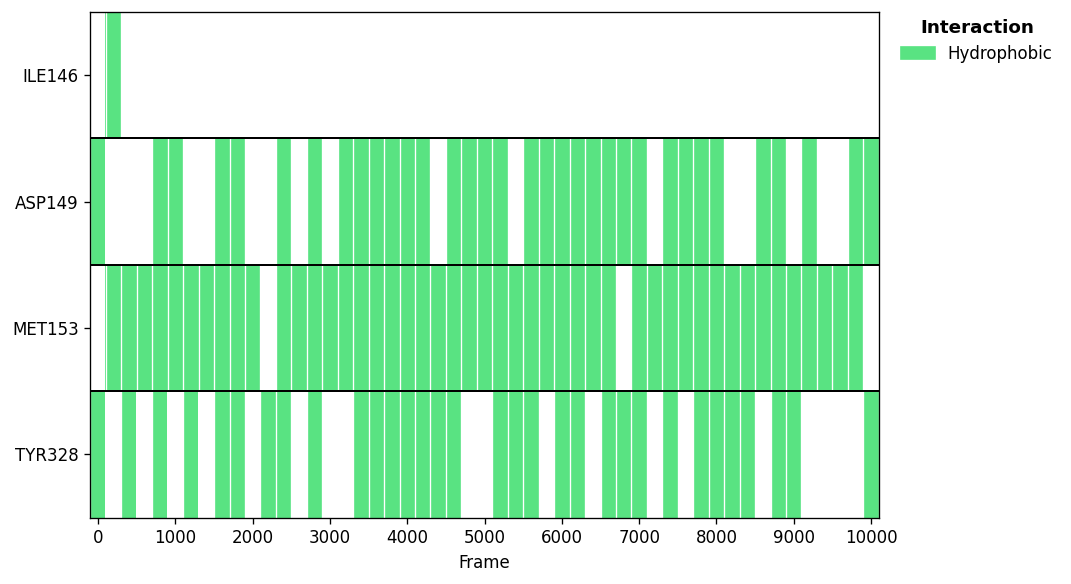

In [22]:
import re
import numpy as np
import matplotlib.pyplot as plt
from prolif.plotting.barcode import Barcode


# ────────────────────────────────────────────────────────────────
# helper ─ plain residue ID from any ProLIF key
# ────────────────────────────────────────────────────────────────
def _plain_id(res):
    """
    Convert one entry from bar.df.index level 0 to 'RES123' (no chain).
    Handles both of ProLIF’s formats:
      • string  "ASP149.A"
      • tuple   ('ASP', 149, 'A')
    """
    if isinstance(res, tuple):                     # ('ASP', 149, 'A')
        return f"{res[0]}{res[1]}"
    # fall-back: stringify and grab letters+digits at start
    m = re.match(r"([A-Za-z]+-?\d+)", str(res))
    return m.group(1) if m else str(res)


def draw_residue_lines(ax, bar, residues_of_interest=None,
                       color="black", linewidth=1.2):
    """
    Overlay a horizontal line AFTER each residue listed in residues_of_interest.
    If residues_of_interest is None → line after **every** residue row.
    """
    # first MI level = per-residue rows (len = n_rows)
    full_ids = bar.df.index.get_level_values(0)
    plain_ids = [_plain_id(r) for r in full_ids]

    # bool: boundary between residue rows (current ≠ next)
    boundaries = np.array(plain_ids[:-1]) != np.array(plain_ids[1:])

    if residues_of_interest is not None:
        mask = np.isin(plain_ids[:-1], list(residues_of_interest))
        boundaries &= mask

    rows = np.where(boundaries)[0]           # indices BEFORE the separator
    if not len(rows):
        return                               # nothing to draw

    y_pos = rows + 0.5                       # between pixel rows
    x_min, x_max = ax.get_xlim()
    ax.hlines(y_pos, x_min, x_max,
              colors=color, linewidths=linewidth, zorder=5)


# ────────────────────────────────────────────────────────────────
# 0 · your Fingerprint object
# ────────────────────────────────────────────────────────────────
# fp = ...   # make sure fp is defined

# ────────────────────────────────────────────────────────────────
# 1 · build barcode figure
# ────────────────────────────────────────────────────────────────
bar = Barcode.from_fingerprint(fp)
ax  = bar.display(figsize=(9, 5),
                  dpi=120,
                  n_frame_ticks=12,
                  residues_tick_location="bottom")

# ────────────────────────────────────────────────────────────────
# 2 · legend: rename the ionic entry
# ────────────────────────────────────────────────────────────────
leg = ax.get_legend()
for txt in leg.get_texts():
    if txt.get_text() == "Cationic":
        txt.set_text("Salt Bridge")
        break
leg.set_title("Interaction", prop={"weight": "bold", "size": 11})
leg.set_bbox_to_anchor((1.02, 1.0))
leg.set_loc("upper left")
leg.get_frame().set_edgecolor("none")

# ────────────────────────────────────────────────────────────────
# 3 · vertical white gaps (frames)
# ────────────────────────────────────────────────────────────────
n_frames = bar.df.shape[1]
ax.set_xticks(np.arange(-0.5, n_frames, 1), minor=True)
ax.grid(which="minor", axis="x", color="white", linewidth=0.8)
ax.tick_params(which="minor", bottom=False)

# ────────────────────────────────────────────────────────────────
# 4 · horizontal separators
#     – list residues OR set to None for all
# ────────────────────────────────────────────────────────────────
horizontal_separator = {"ILE146","ASP149", "MET153", "TYR328"}      # ⇦ edit this set, or None
draw_residue_lines(ax, bar, horizontal_separator,
                   color="black", linewidth=1.2)

# ────────────────────────────────────────────────────────────────
# 5 · show & save
# ────────────────────────────────────────────────────────────────
plt.show()                              # omit in batch scripts




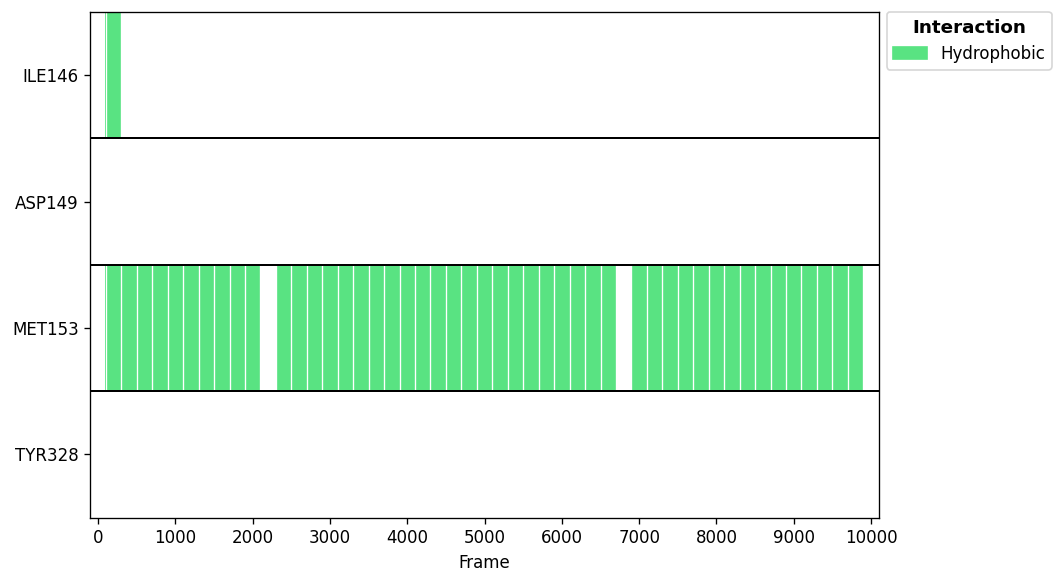

In [25]:
# ────────────────────────────────────────────────────────────────
# imports
# ────────────────────────────────────────────────────────────────
import re
import numpy as np
import matplotlib.pyplot as plt
from prolif.plotting.barcode import Barcode

# ────────────────────────────────────────────────────────────────
# helper ─ plain residue ID from any ProLIF key
# ────────────────────────────────────────────────────────────────
def _plain_id(res):
    """
    Convert one entry from bar.df.index level 0 to 'RES123' (no chain part).
    Handles both of ProLIF’s formats:
      • string  "ASP149.A"
      • tuple   ('ASP', 149, 'A')
    """
    if isinstance(res, tuple):                     # ('ASP', 149, 'A')
        return f"{res[0]}{res[1]}"
    return str(res).split(".")[0]                  # fall-back on string form


def draw_residue_lines(ax, bar, residues_of_interest=None,
                       color="black", linewidth=1.2):
    """
    Overlay a horizontal separator AFTER each residue in residues_of_interest.
    If residues_of_interest is None → separator after every residue row.
    """
    full_ids  = bar.df.index.get_level_values(0)          # first MI level
    plain_ids = [_plain_id(r) for r in full_ids]

    # bool mask: boundary between residue rows (current ≠ next)
    boundaries = np.array(plain_ids[:-1]) != np.array(plain_ids[1:])

    if residues_of_interest is not None:
        mask = np.isin(plain_ids[:-1], list(residues_of_interest))
        boundaries &= mask

    rows = np.where(boundaries)[0]               # indices BEFORE separator
    if not len(rows):
        return                                   # nothing to draw

    y_pos = rows + 0.5                           # between pixel rows
    x_min, x_max = ax.get_xlim()
    ax.hlines(y_pos, x_min, x_max,
              colors=color, linewidths=linewidth, zorder=5)


# ────────────────────────────────────────────────────────────────
# 0 · your Fingerprint object (must already exist)
# ────────────────────────────────────────────────────────────────
# fp = ...

# ────────────────────────────────────────────────────────────────
# 1 · build / slice the DataFrame
# ────────────────────────────────────────────────────────────────
targets = {                                      # (plain residue ID, interaction)
    ("ASP149", "Cationic"),     # Salt-bridge  (will rename later)
    ("ILE146", "Hydrophobic"),
    ("MET153", "Hydrophobic"),
    ("TYR328", "PiStacking"),
}

# keep every column, even if it is all-False
df = fp.to_dataframe(drop_empty=False)  # keeps zero-only columns

# ensure we have an explicit column for every target (creates blank ones)
ligand_id = df.columns.get_level_values("ligand")[0]      # first ligand label
for res, inter in targets:
    present = any((_plain_id(c[1]) == res and c[2] == inter) for c in df.columns)
    if not present:
        df[(ligand_id, res, inter)] = False               # new all-False column

# finally, select only the four columns of interest
cols_to_keep = [c for c in df.columns
                if (_plain_id(c[1]), c[2]) in targets]
df_sel = df[cols_to_keep]

# ────────────────────────────────────────────────────────────────
# 2 · barcode figure
# ────────────────────────────────────────────────────────────────
bar = Barcode(df_sel)
ax  = bar.display(figsize=(9, 5),
                  dpi=120,
                  n_frame_ticks=12,
                  residues_tick_location="bottom")

# ────────────────────────────────────────────────────────────────
# 3 · legend & cosmetics
# ────────────────────────────────────────────────────────────────
leg = ax.get_legend()
for txt in leg.get_texts():               # rename Cationic → Salt Bridge
    if txt.get_text() == "Cationic":
        txt.set_text("Salt Bridge")
        break
leg.set_title("Interaction")                     # create the title
title = leg.get_title()
title.set_fontweight("bold")
title.set_fontsize(11)

# vertical white gaps between frames
n_frames = bar.df.shape[1]
ax.set_xticks(np.arange(-0.5, n_frames, 1), minor=True)
ax.grid(which="minor", axis="x", color="white", linewidth=0.8)
ax.tick_params(which="minor", bottom=False)

# optional horizontal separators
horizontal_separator = {"ASP149", "ILE146", "MET153", "TYR328"}
draw_residue_lines(ax, bar, horizontal_separator,
                   color="black", linewidth=1.2)

plt.show()


In [26]:
fig = ax.figure
fig.savefig("barcodeph7_1.svg", bbox_inches="tight")
fig.savefig("barcodeph7_1.png", dpi=300, bbox_inches="tight")